In [1]:
import cv2
import numpy as np
from numpy.core.defchararray import join, mod
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import os
import torch
from torch._C import device
from torch.autograd.grad_mode import F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator
from PIL import Image
from torchvision import transforms as torchtrans  

In [2]:
labels_path = '../input/guns-object-detection/Labels'
imgs_path = '../input/guns-object-detection/Images'

'../input/guns-object-detection/Labels'

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class gun(Dataset):
    def __init__(self,imgs_path,labels_path):

        self.imgs_path = imgs_path
        self.labels_path = labels_path
        self.img_name = [img for img in sorted(os.listdir(self.imgs_path))]
        self.label_name = [label for label in sorted(os.listdir(self.labels_path))]

    def __getitem__(self,idx):

        image_path = os.path.join(self.imgs_path,str(self.img_name[idx]))
        img = cv2.imread(image_path)
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = img_rgb/255
        img_res = torch.as_tensor(img_res).to(device)
        img_res = img_res.permute(2, 0, 1)
        
        label_name = self.img_name[idx][:-4] + "txt"
        label_path = os.path.join(self.labels_path,str(label_name))
        with open(label_path, 'r') as label_file:
            l_count = int(label_file.readline())
            box = []
            for i in range(l_count):
                box.append(list(map(int, label_file.readline().split())))

        target={}
        target["boxes"] = torch.as_tensor(box).to(device)
        area = []
        for i in range(len(box)):
           
            a = (box[i][2] - box[i][0]) * (box[i][3] - box[i][1])
            area.append(a)
        target["area"] = torch.as_tensor(area).to(device)
        labels = []
        for i in range(len(box)):
            labels.append(1)

        target["image_id"] = torch.as_tensor([idx]).to(device)
        target["labels"] = torch.as_tensor(labels, dtype = torch.int64).to(device)


        return img_res,target

    def __len__(self):
        return len(self.img_name)

In [4]:
#定义训练模型


def model(num):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(
        in_features, num)
    return model


def collate_fn(batch):
    return tuple(zip(*batch))

In [5]:
gun_data = gun(imgs_path, labels_path)
gun_data

In [6]:

data_load = DataLoader(gun_data, batch_size=5,
                       shuffle=True, num_workers=0, collate_fn=collate_fn)
num_class = 2
model = model(num_class)
model.to(device)
num_epoch = 10
param = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.SGD(param,lr=0.01,momentum=0.9)
lr_scheduler = None
for epoch in range(num_epoch):
    loss_num = 0
    model.train()
    for img, target in data_load:
        loss_dic = model(img, target)
        loss = sum(loss for loss in loss_dic.values())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_num += loss
    if lr_scheduler is not None:
        lr_scheduler.step()
    print("eppch:{},loss:{}".format(epoch, loss_num))

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

eppch:0,loss:15.697036743164062
eppch:1,loss:10.317792892456055
eppch:2,loss:8.763084411621094
eppch:3,loss:6.932191848754883
eppch:4,loss:6.219826698303223
eppch:5,loss:5.528941631317139
eppch:6,loss:4.901199817657471
eppch:7,loss:4.516484260559082
eppch:8,loss:4.079690933227539
eppch:9,loss:3.8667452335357666


In [82]:
cpu_device = torch.device("cpu")
model = model.eval()
test_path = '../input/guns-object-detection/Images'
test_data = gun(imgs_path, labels_path)
img,tar = test_data[10]
input = []
input.append(img)
outputs = model(input)


[{'boxes': tensor([[ 15.7648,   9.2227,  66.2987,  56.5271],
          [126.9624,  26.7337, 148.0696,  58.4987]], grad_fn=<CopyBackwards>),
  'labels': tensor([1, 1]),
  'scores': tensor([0.9991, 0.9961], grad_fn=<CopyBackwards>)}]

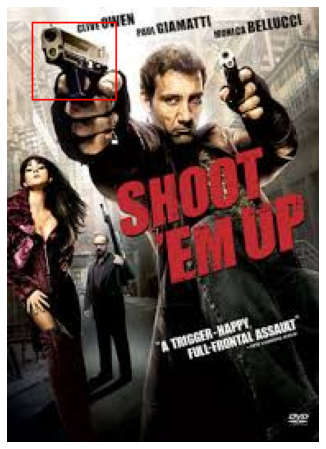

In [83]:
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
boxes = outputs[0]["boxes"].detach().numpy().astype(np.int32)
id = np.argmax(outputs[0]["scores"].detach().numpy())
xmin = boxes[id][0]
xmax = boxes[id][2]
ymin = boxes[id][1]
ymax = boxes[id][3]
img1 = np.array(img.permute(1, 2, 0).to(torch.device("cpu")))

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(img1,(xmin,ymin),(xmax,ymax),(220,0,0),1)
    
ax.set_axis_off()
ax.imshow(img1)
outputs 

[{'boxes': tensor([[ 20.8860,  37.8150,  49.3376,  84.3675],
          [ 99.8637,  34.5677, 134.8410,  64.4111]], grad_fn=<CopyBackwards>),
  'labels': tensor([1, 1]),
  'scores': tensor([0.9979, 0.9976], grad_fn=<CopyBackwards>)}]

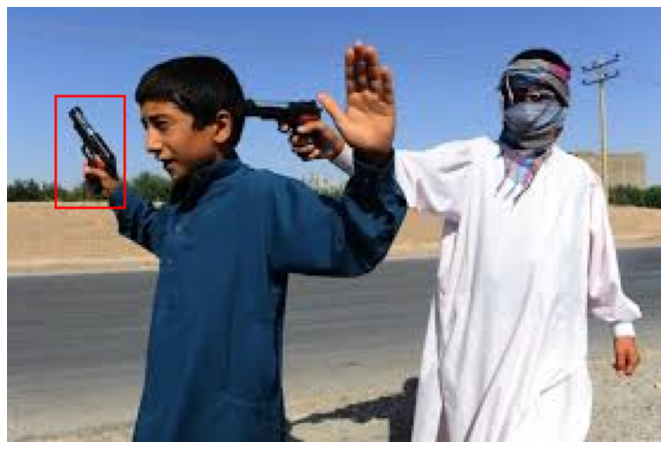

In [67]:
cpu_device = torch.device("cpu")
model = model.eval()
test_path = '../input/guns-object-detection/Images'
test_data = gun(imgs_path, labels_path)
img,tar = test_data[26]
input = []
input.append(img)
outputs = model(input)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
boxes = outputs[0]["boxes"].detach().numpy().astype(np.int32)
id = np.argmax(outputs[0]["scores"].detach().numpy())
xmin = boxes[id][0]
xmax = boxes[id][2]
ymin = boxes[id][1]
ymax = boxes[id][3]
img1 = np.array(img.permute(1, 2, 0).to(torch.device("cpu")))

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(img1,(xmin,ymin),(xmax,ymax),(220,0,0),1)
    
ax.set_axis_off()
ax.imshow(img1)
outputs 

In [18]:
np.array(input)[0].shape

torch.Size([3, 265, 190])

In [68]:
import matplotlib.patches as patches
def apply_nms(orig_prediction, iou_thresh=None):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')


def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

NMS APPLIED MODEL OUTPUT


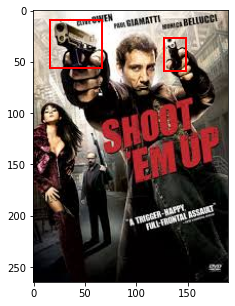

In [90]:
nms_prediction = apply_nms(outputs[0], iou_thresh=0.7)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)


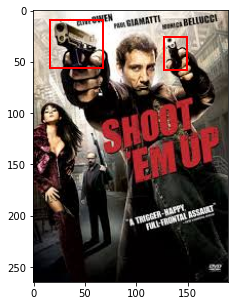

In [11]:
plot_img_bbox(torch_to_pil(img), tar)